In [365]:
from xml.dom.minidom import parse
import json
import numpy as np
import collections
import torch
import random
import dgl
import scipy
import scipy.sparse as spp
import pickle
from tqdm import tqdm
import torch.nn as nn
import dgl.nn as dglnn
import torch.nn.functional as F
from tqdm import tqdm
name='David Cooper'

In [366]:
domTree = parse("./data/raw-data/{0}.xml".format(name))
rootNode = domTree.documentElement
pubs=rootNode.getElementsByTagName("publication")

In [367]:
#这部分是从数据里读出数据
# read data from aminer
paper_data_list=[]
labels=[]
names=[]
for pub in pubs:
    paper={}
    title=pub.getElementsByTagName('title')[0].childNodes[0].data
    year=pub.getElementsByTagName('year')[0].childNodes[0].data
    authors=pub.getElementsByTagName('authors')[0].childNodes[0].data.split(',')
    org=pub.getElementsByTagName('organization')[0].childNodes[0].data
        
    venue=pub.getElementsByTagName('jconf')[0].childNodes[0].data
    label=pub.getElementsByTagName('label')[0].childNodes[0].data
    paper['title']=title
    paper['year']=year
    paper['authors']=[{'name':author,'org':org} for author in authors]
    paper['venue']=venue
    paper['label']=label
    labels.append(int(label))
    paper_data_list.append(paper)
    names.append(authors)
labels=np.array(labels)

In [368]:
#这儿建立coauthor图,两个论文节点之间若有共同作者，即存在边，且保存权重
#create coauthor graph,if two papers have same authors,the edge betwwen papers created,and save weigths 
sum_papers=len(paper_data_list)
coauthor_graph=np.zeros((sum_papers,sum_papers))
name=name.lower().replace('-',' ').replace('_',' ').replace(' ','')
def process_authorname(names,specify):
    result=set()
    for name in names:
        name=name.lower()
        name=name.replace('-',' ').replace('_',' ').replace(' ','')
        if name!=specify:
            result.add(name)
    return result
weights_coauthor=np.zeros((sum_papers,sum_papers))
for i in range(sum_papers):
    for j in range(sum_papers):
        if i !=j:
            authors_i=set(map(lambda x:x['name'],paper_data_list[i]['authors']))
            authors_i=process_authorname(authors_i,name)
            authors_j=set(map(lambda x:x['name'],paper_data_list[j]['authors']))
            authors_j=process_authorname(authors_j,name)
            co_authors=authors_i&authors_j
            
            coauthor_graph[i][j]=coauthor_graph[j][i]=len(co_authors)#这儿是权重图
            weights_coauthor[i][j]=weights_coauthor[j][i]=len(co_authors)
coo_graph=spp.coo_matrix(coauthor_graph)
coauthor_graph=dgl.from_scipy(coo_graph)
#建立权重
coauthor_weight=torch.ones(coauthor_graph.num_edges(),1)

for i,(src,dst) in enumerate(zip(coauthor_graph.edges()[0],coauthor_graph.edges()[1])):
    weight=weights_coauthor[src][dst]
    if weight!=0:
        coauthor_weight[i]=weight
coauthor_graph.edata['weights']=coauthor_weight

In [369]:
#建立cotitle图,将两个结点的title 分词后去除停用词，若两节点的title有共同的词，则存在边，权重为共同词的多少
#create cotitle graph,if two papers's title have the same words,the edge between two papers created,weigths is the num of cotitles
def create_stopwords(path):
    stop_words=[]
    with open(path,'r',encoding='utf-8') as f:
        for line in f:
            word=line.strip()
            stop_words.append(word)
    return stop_words
def remove_stops(title,stop_words):
    title=title.lower().split(' ')
    res=[]
    for word in title:
        if word not in stop_words:
            res.append(word)
    return res
stop_words=create_stopwords('stop_words.txt')#建立停用词

cotitle_graph=np.zeros((sum_papers,sum_papers))
weights_cotitle=np.zeros((sum_papers,sum_papers))
for i in range(sum_papers):
    for j in range(sum_papers):
        if i!=j:
            title_i,title_j=set(remove_stops(paper_data_list[i]['title'],stop_words)),set(remove_stops(paper_data_list[j]['title'],stop_words))
            co_title=title_i&title_j
            cotitle_graph[i][j]=cotitle_graph[j][i]=len(co_title)
            if len(co_title)!=0:
                weights_cotitle[i][j]=weights_cotitle[j][i]=len(co_title)
coo_graph=spp.coo_matrix(cotitle_graph)
cotitle_graph=dgl.from_scipy(coo_graph)
#建立权重
cotitle_weight=torch.ones(cotitle_graph.num_edges(),1)

for i,(src,dst) in enumerate(zip(cotitle_graph.edges()[0],cotitle_graph.edges()[1])):
    weight=weights_cotitle[src][dst]
    if weight!=0:
        cotitle_weight[i]=weight
cotitle_graph.edata['weights']=cotitle_weight

In [370]:
#建立coVenue图
#create covenue graph,if two papers have the same venue,the edge between two papers created 
covenue_graph=torch.zeros((sum_papers,sum_papers))
weights_covenue=np.zeros((sum_papers,sum_papers))
for i in range(sum_papers):
    for j in range(sum_papers):
        if i!=j:
            venue_i,venue_j=paper_data_list[i]['venue'].lower(),paper_data_list[j]['venue'].lower()
            if venue_i=='null' or venue_j=='null':
                continue
            if venue_i==venue_j:
                covenue_graph[i][j]=covenue_graph[j][i]=1
                weights_covenue[i][j]=weights_covenue[j][i]=1
coo_graph=spp.coo_matrix(covenue_graph)
covenue_graph=dgl.from_scipy(coo_graph)

covenue_weight=torch.ones(covenue_graph.num_edges(),1)
for i,(src,dst) in enumerate(zip(covenue_graph.edges()[0],covenue_graph.edges()[1])):
    weight=weights_covenue[src][dst]
    if weight!=0:
        covenue_weight[i]=weight
covenue_graph.edata['weights']=covenue_weight

In [371]:
#按照论文所写，这里需要使用Doc2Vec对abstracts,title进行向量化
#according to the paper,here we use the DOc2vec to get the title,abstracts embdding.
titles=list(map(lambda x:x['title'].lower(),paper_data_list))
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
#这是对titles进行doc2vec
corpora_documents = []
doc=[] 
for i, item_text in enumerate(titles):
    words_list=[]
    item_text=item_text.replace('.','').replace(',','').lower()
    item=(item_text.split(' '))
    for j in list(item):
        words_list.append(j)
    document = TaggedDocument(words=words_list, tags=[i])
    corpora_documents.append(document)
    doc.append(words_list)
model_t=Doc2Vec(corpora_documents,min_count=1,window=3,dm=0)
model_t.train(corpora_documents, total_examples=model_t.corpus_count, epochs=70)
titles_vec=[model_t.infer_vector(line.replace(',','').replace('.','').lower().split(' ')) for line in titles]
titles_vec=torch.tensor(titles_vec)
node_features=titles_vec


In [372]:
hete_graph=dgl.heterograph({
    ('paper','coauthor','paper'):coauthor_graph.edges(),
    ('paper','cotitle','paper'):cotitle_graph.edges(),
    ('paper','covenue','paper'):covenue_graph.edges()
})

In [373]:
def positive_sampler(path):
    pos_u,pos_v=[],[]
    for i in range(len(path)):
        if len(path)==1:
            continue
        u=path[i]
        v=np.concatenate([path[max(i-window,0):i],path[i+1:i+window+1]],axis=0)
        pos_u.extend([u]*len(v))
        pos_v.extend(v)
    return pos_u,pos_v    
def get_negative_ratio(metapath):
    node_frequency=dict()
    sentence_count,node_count=0,0
    for path in metapath:
        for node in path:
            node_frequency[node]=node_frequency.get(node,0)+1
            node_count+=1
    pow_frequency=np.array(list(map(lambda x:x[-1],sorted(node_frequency.items(),key=lambda asd:asd[0]))))**0.75
    node_pow=np.sum(pow_frequency)
    ratio=pow_frequency/node_pow
    return ratio
def negative_sampler(path,ratio,nodes):
    negtives_size=5
    negatives=[]
    while len(negatives)<5:
        temp=np.random.choice(nodes, size=negtives_size-len(negatives), replace=False, p=ratio)
        negatives.extend([node for node in temp if node not in path])
    return negatives

In [374]:
def create_node2node_dict(graph):
    src_dst={}
    for src,dst in zip(graph.edges()[0],graph.edges()[1]):
        src,dst=src.item(),dst.item()
        if src not in src_dst.keys():
            src_dst[src]=[]
        src_dst[src].append(dst)
    return src_dst
window=2# 这里是取metapath时的窗口大小
metapaths=[]#所有的metapath
num_walks=10#每个结点run 多少遍
walk_len=100#每个path的长度
metapath_type=['coauthor','covenue','coauthor','cotitle']#根据论文，作者使用的是AVAT

edge_per_graph={}#对应每个图，建立个字典，每个字典的key为结点编号，value为key在该图中可以到达的结点编号
edge_per_graph['coauthor']=create_node2node_dict(coauthor_graph)
edge_per_graph['cotitle']=create_node2node_dict(cotitle_graph)
edge_per_graph['covenue']=create_node2node_dict(covenue_graph)
weights_all_graph={'coauthor':weights_coauthor,'cotitle':weights_cotitle,'covenue':weights_covenue}

def Is_isolate(node):
    for rel in metapath_type:
        if node in edge_per_graph[rel].keys():
            return 0
    return 1
for walk in tqdm(range(num_walks)):
    for cur_node in list(range(len(labels))):
        stop=0
        path=[]
        path.append(cur_node)
        while len(path)<walk_len and stop==0:
            for rel in metapath_type:
                if len(path)==walk_len or Is_isolate(cur_node):
                    stop=1
                    break
                if edge_per_graph[rel].get(cur_node,-1)==-1:
                    continue
                    
                cand_nodes=edge_per_graph[rel][cur_node]
                weights_per_candnodes=weights_all_graph[rel][cur_node][cand_nodes]

                weighted_ratio=weights_per_candnodes*1.0/np.sum(weights_per_candnodes)
                cur_node=np.random.choice(cand_nodes,size=1,p=weighted_ratio)[0]
                path.append(cur_node)
        metapaths.append(path)

pos_us,pos_vs,neg_vs=[],[],[]
nodes=list(range(sum_papers))
ratio=get_negative_ratio(metapaths)
for path in metapaths:
    pos_u,pos_v=positive_sampler(path)
    for u,v in zip(pos_u,pos_v):
        negative_nodes=negative_sampler(path,ratio,nodes)
        neg_vs.append(negative_nodes)
    pos_us.extend(pos_u)
    pos_vs.extend(pos_v)
pos_us=torch.LongTensor(pos_us)
pos_vs=torch.LongTensor(pos_vs)
neg_vs=torch.LongTensor(neg_vs)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.61it/s]


In [387]:
from torch.nn import init
class RGCN(nn.Module):
    def __init__(self,in_features,hidden_features,n_classes):
        super(RGCN,self).__init__()
        self.conv1_1=dglnn.SAGEConv(in_feats=in_features,out_feats=hidden_features,aggregator_type='gcn')
        self.conv1_2=dglnn.SAGEConv(in_feats=hidden_features,out_feats=n_classes,aggregator_type='gcn')
        
        self.conv2_1=dglnn.SAGEConv(in_feats=in_features,out_feats=hidden_features,aggregator_type='gcn')
        self.conv2_2=dglnn.SAGEConv(in_feats=hidden_features,out_feats=n_classes,aggregator_type='gcn')

        self.conv3_1=dglnn.SAGEConv(in_feats=in_features,out_feats=hidden_features,aggregator_type='gcn')
        self.conv3_2=dglnn.SAGEConv(in_feats=hidden_features,out_feats=n_classes,aggregator_type='gcn')
        
        self.dropout=nn.Dropout(0.1)
        self.batch_norm1=nn.BatchNorm1d(in_features)
        self.batch_norm2=nn.BatchNorm1d(hidden_features)
        self.batch_norm3=nn.BatchNorm1d(n_classes)
    def forward(self,graph1,graph2,graph3,x):
        x=self.batch_norm1(x)
        x=self.dropout(x)
        x1_1=self.conv1_1(graph1,x)
        x1_2=self.conv2_1(graph2,x)
        x1_3=self.conv3_1(graph3,x)
        x=F.relu(x1_1+x1_2+x1_3)
        x=self.batch_norm2(x)
        x=self.dropout(x)
        x2_1=self.conv1_2(graph1,x)
        x2_2=self.conv2_2(graph2,x)
        x2_3=self.conv3_2(graph3,x)
        x=x2_1+x2_2+x2_3
        x=self.batch_norm3(x)
        return x
class SkipGramModel(nn.Module):

    def __init__(self):
        super(SkipGramModel, self).__init__()
    def forward(self, pos_u, pos_v, neg_v,logits):
        emb_u = logits[pos_u]
        emb_v = logits[pos_v]
        emb_neg_v = logits[neg_v]

        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -F.logsigmoid(score)

        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = -torch.sum(F.logsigmoid(-neg_score), dim=1)

        return torch.mean(score + neg_score),score,neg_score

In [389]:
model=RGCN(node_features.shape[-1],128,64)
skip_model=SkipGramModel()
optimizer=torch.optim.Adam(nn.ModuleList([skip_model,model]).parameters(),lr=0.001,weight_decay=0.0001)
losses=[]
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    logits=model(coauthor_graph,cotitle_graph,covenue_graph,node_features)
    loss,score,neg_score=skip_model(torch.tensor(pos_us),torch.tensor(pos_vs),torch.tensor(neg_vs),logits)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch %20==0:
        print('epoch {0}  loss {1}'.format(epoch,loss))

c:\python3.6\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


epoch 0  loss 3.219543695449829
epoch 20  loss 1.4345829486846924
epoch 40  loss 0.7769383788108826
epoch 60  loss 0.6995971202850342
epoch 80  loss 0.6900938153266907
epoch 100  loss 0.6867356896400452
epoch 120  loss 0.6592167615890503
epoch 140  loss 0.7181817293167114
epoch 160  loss 0.6571433544158936
epoch 180  loss 0.6265724301338196


Kmeans  F值为 0.5932098765432099


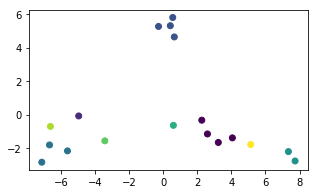

C:\GNN\fuxian\metrics.py:20: RuntimeWarning: invalid value encountered in true_divide
  F=(2* precision*recall)/(precision+recall)


AP  F值为 0.7217171717171719


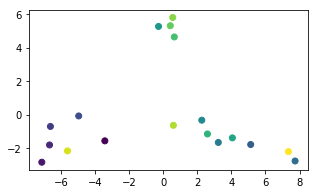

C:\GNN\fuxian\metrics.py:20: RuntimeWarning: invalid value encountered in true_divide
  F=(2* precision*recall)/(precision+recall)


XMeans  F值为 0.4916666666666667


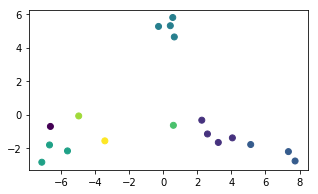

C:\GNN\fuxian\metrics.py:20: RuntimeWarning: invalid value encountered in true_divide
  F=(2* precision*recall)/(precision+recall)


In [391]:
from sklearn.cluster import KMeans,AffinityPropagation
from xmeans import XMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from metrics import get_Fscore
model.eval()
logits=model(coauthor_graph,cotitle_graph,covenue_graph,node_features).detach().numpy()
n_classes=len(set(labels))
pca=PCA(n_components=2)
X_pca = pca.fit_transform(logits)


cluster_methods={'Kmeans':KMeans(n_clusters=n_classes),'AP':AffinityPropagation(preference=-1),'XMeans':XMeans(kmax=10)}
i=1
for cluster_name,method in cluster_methods.items():
    plt.figure(figsize=(5,10))
    plt.subplot(len(cluster_methods),1,i)
    if cluster_name!='XMeans':
        y_pred=method.fit_predict(logits)
    else:
        method.fit(logits)
        y_pred=method.labels_
        
    plt.scatter(X_pca[:,0],X_pca[:,1],c=y_pred)
    plt.show()
    F_score=get_Fscore(labels,y_pred)
    print(cluster_name,' F值为',F_score)
    
    i+=1

In [392]:
#单纯的metapath2vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

"""
    u_embedding: Embedding for center word.
    v_embedding: Embedding for neighbor words.
"""


class SkipGramModel2(nn.Module):

    def __init__(self, emb_size, emb_dimension):
        super(SkipGramModel2, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size, emb_dimension)
        self.v_embeddings = nn.Embedding(emb_size, emb_dimension)

        initrange = 1.0 / self.emb_dimension
        init.uniform_(self.u_embeddings.weight.data, -initrange, initrange)
        init.constant_(self.v_embeddings.weight.data, 0)

    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        emb_neg_v = self.v_embeddings(neg_v)

        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -F.logsigmoid(score)

        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = -torch.sum(F.logsigmoid(-neg_score), dim=1)

        return torch.mean(score + neg_score)

In [ ]:
skip_model2=SkipGramModel2(sum_papers,64)
optimizer=torch.optim.Adam(skip_model2.parameters(),lr=0.001)
for epoch in range(500):
    optimizer.zero_grad()
    loss=skip_model2(torch.tensor(pos_us),torch.tensor(pos_vs),torch.tensor(neg_vs))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch %100==0:
        print('epoch {0}  loss {1}'.format(epoch,loss))

c:\python3.6\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


epoch 0  loss 4.158882141113281
epoch 100  loss 2.2629382610321045
epoch 200  loss 1.0820413827896118


In [ ]:
from sklearn.cluster import KMeans,AffinityPropagation
from xmeans import XMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from metrics import get_Fscore

logits=skip_model2.u_embeddings.weight.cpu().data.numpy()

pca=PCA(n_components=2)
X_pca = pca.fit_transform(logits)


cluster_methods={'Kmeans':KMeans(n_clusters=n_classes),'AP':AffinityPropagation(preference=-60),'XMeans':XMeans(kmax=30)}
i=1
for cluster_name,method in cluster_methods.items():
    print(cluster_name,' F值为',F_score)
    plt.figure(figsize=(5,10))
    plt.subplot(len(cluster_methods),1,i)
    if cluster_name!='XMeans':
        y_pred=method.fit_predict(logits)
    else:
        method.fit(logits)
        y_pred=method.labels_
        
    plt.scatter(X_pca[:,0],X_pca[:,1],c=y_pred)
    plt.show()
    F_score=get_Fscore(labels,y_pred)
    
    i+=1